In [1]:
''' 
Data analysis used for the "Binary Catalog" section of the paper. Notebook does the following:

A. Quality Cuts (Except Completeness Cut)
    1. Split binaries into photometric samples
    2. From MSMS binaries, apply kinematic cuts to get kinematic subsamples
B. Determining stellar masses
    1. Divides stellar components into photometric primaries and secondaries
    2. Corrects stellar color-magnitude diagram for extinction
    3. Interpolates the CMD over MIST isochrones to estimate the masses and metallicities of the stars
    4. Stores the data in numpy arrays
C. Completeness cut
    1. Fitting \theta_0 for every \Delta G
    2. Fitting \theta_\Delta G defined such that f_\Delta G = 0.999
    3. Select binaries with f_\Delta G > 0.999
'''

' \nData analysis used for the "Binary Catalog" section of the paper. Notebook does the following:\n\nA. Quality Cuts (Except Completeness Cut)\n    1. Split binaries into photometric samples\n    2. From MSMS binaries, apply kinematic cuts to get kinematic subsamples\nB. Determining stellar masses\n    1. Divides stellar components into photometric primaries and secondaries\n    2. Corrects stellar color-magnitude diagram for extinction\n    3. Interpolates the CMD over MIST isochrones to estimate the masses and metallicities of the stars\n    4. Stores the data in numpy arrays\nC. Completeness cut\n    1. Fitting \theta_0 for every \\Delta G\n    2. Fitting \theta_\\Delta G defined such that f_\\Delta G = 0.999\n    3. Select binaries with f_\\Delta G > 0.999\n'

In [2]:
# Basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# load el-badry eDR3 wide binary catalog
## need to download all_columns_catalog.fits file from arXiv:2101.05282v3
## quick link to catalog: https://zenodo.org/record/4435257
from astropy.table import Table
dat = Table.read('all_columns_catalog.fits', format='fits')
cdf = dat.to_pandas()

In [4]:
cdf['log_sep_AU'] = np.log10(cdf['sep_AU'])

# split samples by spectral types
is_MSMS = cdf['binary_type']==b'MSMS'
cdf_MSMS = cdf[is_MSMS]

is_WDMS = cdf['binary_type']==b'WDMS'
cdf_WDMS = cdf[is_WDMS]

is_WDWD = cdf['binary_type']==b'WDWD'
cdf_WDWD = cdf[is_WDWD]

is_MSQQ = cdf['binary_type']==b'MS??'
cdf_MSQQ = cdf[is_MSQQ]

(1, 200000)

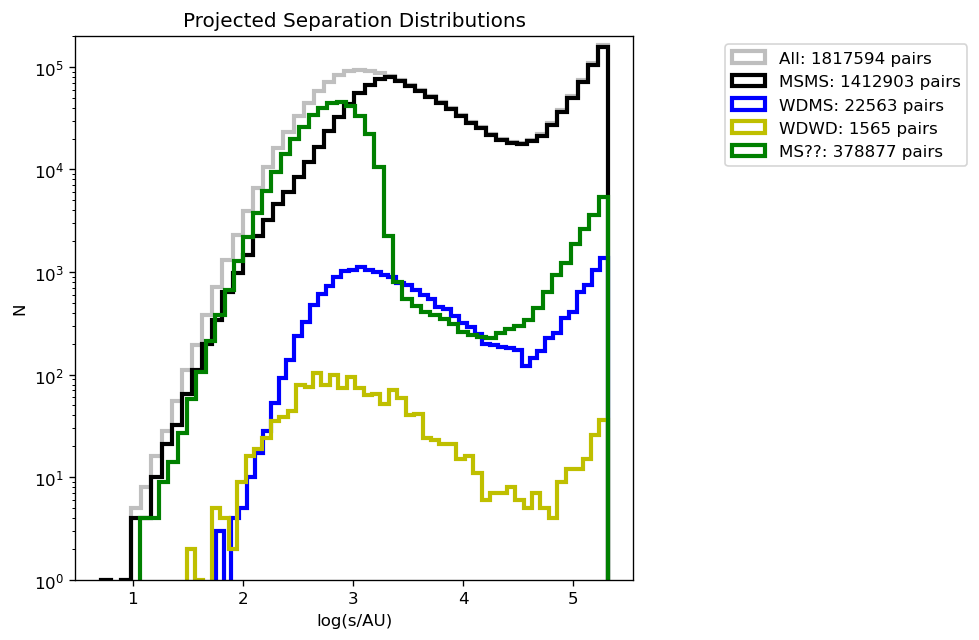

In [5]:
fig = plt.figure(figsize=(6,6), dpi= 120)
ax = fig.add_subplot(111)

counts, bins, _ = ax.hist((cdf['log_sep_AU']) , bins = 50, color = 'k', alpha = 0.25, lw = 2.5, histtype = 'step', density = False,
                         label = 'All: ' + str(len(cdf['log_sep_AU'])) + ' pairs')

counts, bins, _ = ax.hist((cdf_MSMS['log_sep_AU']) , bins = 50, color = 'k', alpha = 1, lw = 2.5, histtype = 'step', density = False,
                         label = 'MSMS: ' + str(len(cdf_MSMS['log_sep_AU'])) + ' pairs')

counts, bins, _ = ax.hist((cdf_WDMS['log_sep_AU']) , bins = 50, color = 'b', alpha = 1, lw = 2.5, histtype = 'step', density = False,
                         label = 'WDMS: ' + str(len(cdf_WDMS['log_sep_AU'])) + ' pairs')

counts, bins, _ = ax.hist((cdf_WDWD['log_sep_AU']) , bins = 50, color = 'y', alpha = 1, lw = 2.5, histtype = 'step', density = False,
                         label = 'WDWD: ' + str(len(cdf_WDWD['log_sep_AU'])) + ' pairs')

counts, bins, _ = ax.hist((cdf_MSQQ['log_sep_AU']) , bins = 50, color = 'g', alpha = 1, lw = 2.5, histtype = 'step', density = False,
                         label = 'MS??: ' + str(len(cdf_MSQQ['log_sep_AU'])) + ' pairs')

ax.legend(bbox_to_anchor=(1.15, 1), loc='upper left', ncol=1)

ax.set_xlabel('log(s/AU)')
ax.set_ylabel('N')
ax.set_title('Projected Separation Distributions')

ax.set_yscale('log')
ax.set_ylim([1,200000])

In [6]:
# Obtain disk, intermediate, and halo binaries via the kinematic cuts described in arXiv:1909.04765

cdf_MSMS['distance1'] = 1000 * (1/cdf_MSMS['parallax1'])    # distance to 1st star (pc) 
cdf_MSMS['distance2'] = 1000 * (1/cdf_MSMS['parallax2'])    # distance to 2nd star (pc)
cdf_MSMS['mg1'] = cdf_MSMS['phot_g_mean_mag1'] - 5 * np.log10(cdf_MSMS['distance1']) + 5 # Observed G-band magnitude
cdf_MSMS['color1'] = cdf_MSMS['phot_bp_mean_mag1'] - cdf_MSMS['phot_rp_mean_mag1'] # Color index
cdf_MSMS['mg2'] = cdf_MSMS['phot_g_mean_mag2'] - 5 * np.log10(cdf_MSMS['distance2']) + 5
cdf_MSMS['color2'] = cdf_MSMS['phot_bp_mean_mag2'] - cdf_MSMS['phot_rp_mean_mag2']

cdf_MSMS['tangential_vel'] = 4.74 * ( 1/2 * (np.sqrt(
    (cdf_MSMS['pmra1'] + cdf_MSMS['pmra2'])**2 + 
    (cdf_MSMS['pmdec1'] + cdf_MSMS['pmdec2'])**2 ) ) ) / cdf_MSMS['parallax1']

cdf_MSMS['delta_pmra'] = (cdf_MSMS['pmra1'] - cdf_MSMS['pmra2'])
cdf_MSMS['delta_pmdec'] = (cdf_MSMS['pmdec1'] - cdf_MSMS['pmdec2'])
cdf_MSMS['delta_mu'] = np.sqrt( (cdf_MSMS['delta_pmra'])**2 + 
                                             (cdf_MSMS['delta_pmdec'])**2  )

cdf_MSMS['pairdistance_arcsec'] = cdf_MSMS['pairdistance'] * 60 * 60
cdf_MSMS['delta_mu_orbit'] = 0.44 * (cdf_MSMS['parallax1'])**(3/2) * (cdf_MSMS['pairdistance_arcsec'])**(-1/2)
cdf_MSMS['sigma_delta_mu'] = ( (1 / cdf_MSMS['delta_mu']) * np.sqrt( 
    (cdf_MSMS['pmra_error1']**2 + cdf_MSMS['pmra_error2']**2) * (cdf_MSMS['delta_pmra'])**2 + 
    (cdf_MSMS['pmdec_error1']**2 + cdf_MSMS['pmdec_error2']**2) * (cdf_MSMS['delta_pmdec'])**2 ) )

# =====================
distance_disk_pc = 120. 
is_disk_distance = (cdf_MSMS['distance1']<distance_disk_pc)

cdf_disk_distance = cdf_MSMS[is_disk_distance]

vel_disk_kms = 40.
is_disk_vel = (cdf_disk_distance['tangential_vel']<vel_disk_kms)
cdf_disk_vel = cdf_disk_distance[is_disk_vel]

is_disk_pure = ((cdf_disk_vel['binary_type']==b'MSMS') & 
                (cdf_disk_vel['sigma_delta_mu'] <= 0.12) & 
                (cdf_disk_vel['delta_mu'] <= cdf_disk_vel['delta_mu_orbit'] + cdf_disk_vel['sigma_delta_mu'])
               )
cdf_disk = cdf_disk_vel[is_disk_pure]

# ======================

distance_inter_pc = 300. 
is_inter_distance = (cdf_MSMS['distance1']<distance_inter_pc)

cdf_inter_distance = cdf_MSMS[is_inter_distance]

vel_inter_kms_lower = 40.
vel_inter_kms_higher = 85.
is_inter_vel = ( (cdf_inter_distance['tangential_vel']>vel_inter_kms_lower) & 
                 (cdf_inter_distance['tangential_vel']<vel_inter_kms_higher) )
cdf_inter_vel = cdf_inter_distance[is_inter_vel]

is_inter_pure = ((cdf_inter_vel['binary_type']==b'MSMS') & 
                 (cdf_inter_vel['sigma_delta_mu'] <= 0.12) & 
                 (cdf_inter_vel['delta_mu'] <= cdf_inter_vel['delta_mu_orbit'] + cdf_inter_vel['sigma_delta_mu'])
                )
cdf_inter = cdf_inter_vel[is_inter_pure]

# ======================

distance_halo_pc = 700. 
is_halo_distance = (cdf_MSMS['distance1']<distance_halo_pc)

cdf_halo_distance = cdf_MSMS[is_halo_distance]

vel_halo_kms = 85.
is_halo_vel = (cdf_halo_distance['tangential_vel']>vel_halo_kms)
cdf_halo_vel = cdf_halo_distance[is_halo_vel]

is_halo_pure = ((cdf_halo_vel['binary_type']==b'MSMS') & 
                (cdf_halo_vel['sigma_delta_mu'] <= 0.12) & 
                (cdf_halo_vel['delta_mu'] <= cdf_halo_vel['delta_mu_orbit'] + cdf_halo_vel['sigma_delta_mu'])
               )
cdf_halo = cdf_halo_vel[is_halo_pure]

/tmp/ipykernel_110/1246472316.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf_MSMS['distance1'] = 1000 * (1/cdf_MSMS['parallax1'])    # distance to 1st star (pc)
/tmp/ipykernel_110/1246472316.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf_MSMS['distance2'] = 1000 * (1/cdf_MSMS['parallax2'])    # distance to 2nd star (pc)
/tmp/ipykernel_110/1246472316.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

(1, 200000)

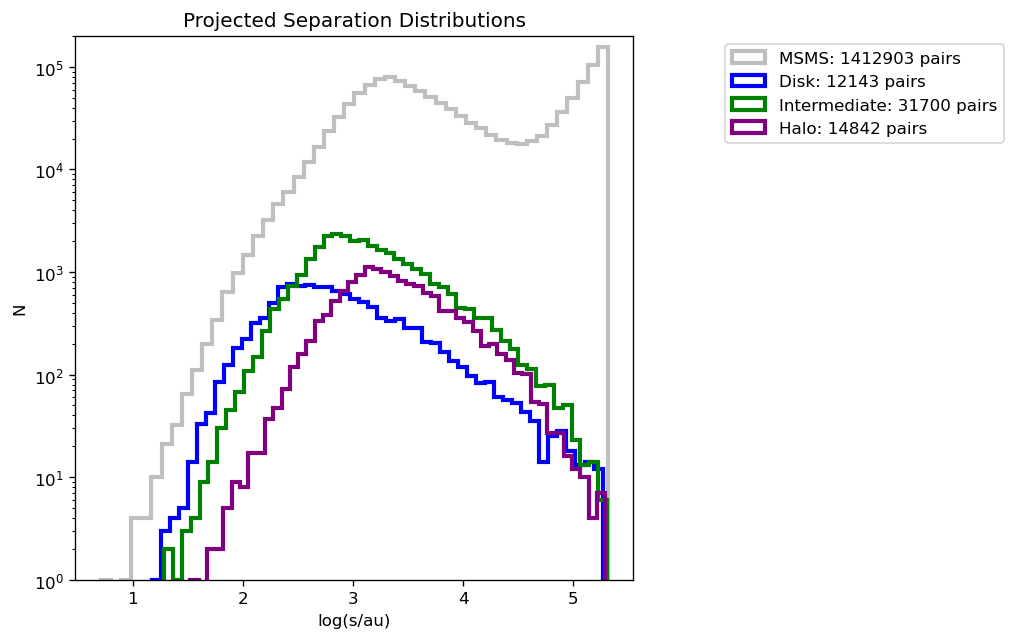

In [7]:
fig = plt.figure(figsize=(6,6), dpi= 120)
ax = fig.add_subplot(111)

counts, bins, _ = ax.hist((cdf_MSMS['log_sep_AU']) , bins = 50, color = 'k', alpha = 0.25, lw = 2.5, histtype = 'step', density = False,
                         label = 'MSMS: ' + str(len(cdf_MSMS['log_sep_AU'])) + ' pairs')

counts, bins, _ = ax.hist((cdf_disk['log_sep_AU']) , bins = 50, color = 'b', alpha = 1, lw = 2.5, histtype = 'step', density = False,
                         label = 'Disk: ' + str(len(cdf_disk['log_sep_AU'])) + ' pairs')

counts, bins, _ = ax.hist((cdf_inter['log_sep_AU']) , bins = 50, color = 'g', alpha = 1, lw = 2.5, histtype = 'step', density = False,
                         label = 'Intermediate: ' + str(len(cdf_inter['log_sep_AU'])) + ' pairs')

counts, bins, _ = ax.hist((cdf_halo['log_sep_AU']) , bins = 50, color = 'purple', alpha = 1, lw = 2.5, histtype = 'step', density = False,
                         label = 'Halo: ' + str(len(cdf_halo['log_sep_AU'])) + ' pairs')

ax.legend(bbox_to_anchor=(1.15, 1), loc='upper left', ncol=1)

ax.set_xlabel('log(s/au)')
ax.set_ylabel('N')
ax.set_title('Projected Separation Distributions')

ax.set_yscale('log')
ax.set_ylim([1,200000])

In [8]:
cdf_halo.to_pickle('halo_catalog_dataframe.pkl')

---
---
---

In [1]:
# Basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
### Load the raw catalog data

cdf_halo_tot = pd.read_pickle('halo_catalog_dataframe.pkl')
cdf_halo_tot.reset_index(drop=True, inplace=True)

In [3]:
# Filter by chance alignment probability and separations

R_chance_align = 1
str_R_chance_align = str(float(R_chance_align))

scut = 1
str_scut = str(float(scut))

pc_AU = 4.84814e-6 # pc/AU
cdf_halo_tot['sep_pc'] = cdf_halo_tot['sep_AU'] * pc_AU

is_R_chance_align = (cdf_halo_tot['R_chance_align'] < R_chance_align) 
is_below_scut =  (cdf_halo_tot['sep_pc'] < scut) 

cdf_halo = cdf_halo_tot[is_R_chance_align & is_below_scut]
cdf_halo.reset_index(drop=True, inplace=True)

(1, 15000)

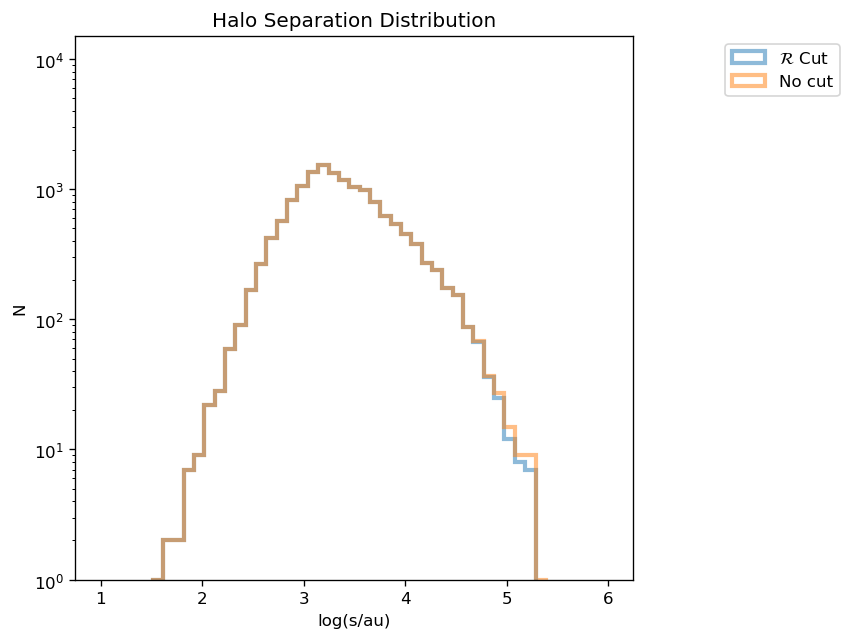

In [4]:
fig = plt.figure(figsize=(6,6), dpi= 120)
ax = fig.add_subplot(111)

counts, bins, _ = ax.hist((cdf_halo['log_sep_AU']) , bins = np.linspace(1,6,50), lw = 2.5, histtype = 'step', density = False,
                     label = '$\mathcal{R}$ Cut', alpha = 0.5)
counts, bins, _ = ax.hist((cdf_halo_tot['log_sep_AU']) , bins = np.linspace(1,6,50), lw = 2.5, histtype = 'step', density = False,
                     label = 'No cut', alpha = 0.5)
    
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper left', ncol=1)

ax.set_xlabel('log(s/au)')
ax.set_ylabel('N')
ax.set_title('Halo Separation Distribution')

ax.set_yscale('log')
ax.set_ylim([1,15000])

In [5]:
### Create columns separating the data into primary and secondary observables
### Primary (secondary) dataframe consists of stars brighter (fainter) than their companion

## Defining which star is primary or secondary
cdf_halo['g_p'] = cdf_halo[['phot_g_mean_mag1','phot_g_mean_mag2']].min(axis = 1) # note: min because primary has more negative mag
cdf_halo['g_s'] = cdf_halo[['phot_g_mean_mag1','phot_g_mean_mag2']].max(axis = 1) # note: max because secondary has more positive mag

## Initialize new columns for primary and secondary observables
N = len(cdf_halo['phot_g_mean_mag1']) # number of binaries in catalog

cdf_halo['color_p'] = np.zeros(N) # primary color index (dex)
cdf_halo['color_s'] = np.zeros(N) # secondary color index (dex)
cdf_halo['mg_p'] = np.zeros(N) # G-band absolute magnitude (dex)
cdf_halo['mg_s'] = np.zeros(N) # G-band absolute magnitude (dex)

cdf_halo['bp_p'] = np.zeros(N) # G_BP-band magnitude (dex)
cdf_halo['bp_s'] = np.zeros(N) # G_BP-band magnitude (dex)
cdf_halo['rp_p'] = np.zeros(N) # G_RP-band magnitude (dex)
cdf_halo['rp_s'] = np.zeros(N) # G_RP-band magnitude (dex)

cdf_halo['ra_p'] = np.zeros(N) # right ascension (deg)
cdf_halo['ra_s'] = np.zeros(N) # right ascension (deg)
cdf_halo['dec_p'] = np.zeros(N) # declination (deg)
cdf_halo['dec_s'] = np.zeros(N) # declination (deg)
cdf_halo['d_p'] = np.zeros(N) # distance (pc)
cdf_halo['d_s'] = np.zeros(N) # distance (pc)

## separate data into primary (_p) and secondary (_s) observables
for n in range(N):
    mag_primary = cdf_halo['g_p'][n]
    mag_ = cdf_halo['phot_g_mean_mag1'][n]
    if mag_primary == mag_: 
        cdf_halo['color_p'][n] = cdf_halo['color1'][n]
        cdf_halo['color_s'][n] = cdf_halo['color2'][n]
        cdf_halo['mg_p'][n] = cdf_halo['mg1'][n]
        cdf_halo['mg_s'][n] = cdf_halo['mg2'][n]
        
        cdf_halo['bp_p'][n] = cdf_halo['phot_bp_mean_mag1'][n]
        cdf_halo['bp_s'][n] = cdf_halo['phot_bp_mean_mag2'][n]
        cdf_halo['rp_p'][n] = cdf_halo['phot_rp_mean_mag1'][n]
        cdf_halo['rp_s'][n] = cdf_halo['phot_rp_mean_mag2'][n]

        cdf_halo['ra_p'][n] = cdf_halo['ra1'][n]
        cdf_halo['ra_s'][n] = cdf_halo['ra2'][n]
        cdf_halo['dec_p'][n] = cdf_halo['dec1'][n]
        cdf_halo['dec_s'][n] = cdf_halo['dec2'][n]
        cdf_halo['d_p'][n] = cdf_halo['distance1'][n]
        cdf_halo['d_s'][n] = cdf_halo['distance2'][n]
        
    else:
        cdf_halo['color_p'][n] = cdf_halo['color2'][n]
        cdf_halo['color_s'][n] = cdf_halo['color1'][n]
        cdf_halo['mg_p'][n] = cdf_halo['mg2'][n]
        cdf_halo['mg_s'][n] = cdf_halo['mg1'][n]
        
        cdf_halo['bp_p'][n] = cdf_halo['phot_bp_mean_mag2'][n]
        cdf_halo['bp_s'][n] = cdf_halo['phot_bp_mean_mag1'][n]
        cdf_halo['rp_p'][n] = cdf_halo['phot_rp_mean_mag2'][n]
        cdf_halo['rp_s'][n] = cdf_halo['phot_rp_mean_mag1'][n]
        
        cdf_halo['ra_p'][n] = cdf_halo['ra2'][n]
        cdf_halo['ra_s'][n] = cdf_halo['ra1'][n]
        cdf_halo['dec_p'][n] = cdf_halo['dec2'][n]
        cdf_halo['dec_s'][n] = cdf_halo['dec1'][n]
        cdf_halo['d_p'][n] = cdf_halo['distance2'][n]
        cdf_halo['d_s'][n] = cdf_halo['distance1'][n]

/tmp/ipykernel_132/2888914299.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf_halo['g_p'] = cdf_halo[['phot_g_mean_mag1','phot_g_mean_mag2']].min(axis = 1) # note: min because primary has more negative mag
/tmp/ipykernel_132/2888914299.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf_halo['g_s'] = cdf_halo[['phot_g_mean_mag1','phot_g_mean_mag2']].max(axis = 1) # note: max because secondary has more positive mag
/tmp/ipykernel_132/2888914299.py:11: SettingWithCopyWarning: 
A value is trying to

/tmp/ipykernel_132/3087844044.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf_halo['s_pc'] = cdf_halo['sep_AU'] * pc_AU


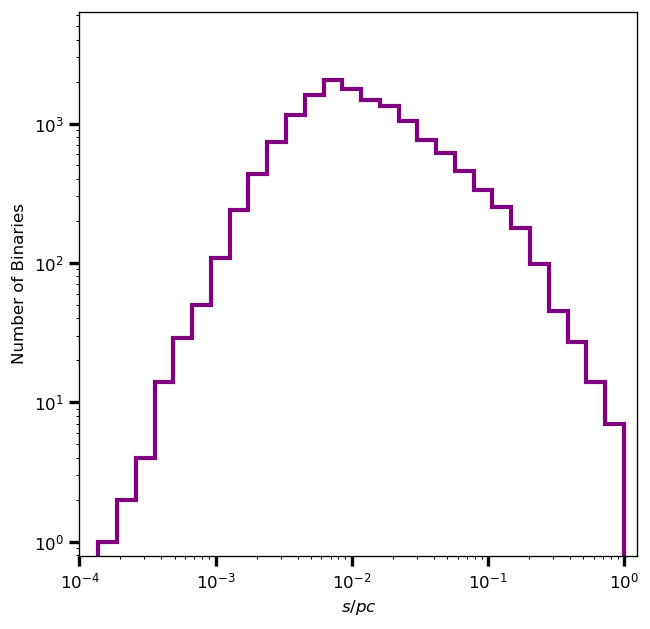

In [6]:
### Separation Distribution

pc_AU = 4.84814e-6
cdf_halo['s_pc'] = cdf_halo['sep_AU'] * pc_AU

### Generate a histogram of the total masses

fig = plt.figure(figsize=(6, 6), dpi= 120)

ax = fig.add_subplot(111)
counts, bins, _ = ax.hist((cdf_halo['s_pc']) , bins = np.logspace(-4,0,30), color = 'purple', alpha = 1, lw = 2.5, histtype = 'step', density = False)
ax.set_xlabel('$s/pc$')
ax.set_ylabel('Number of Binaries')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([10**-4,10**0.1])
ax.set_ylim([10**-0.1,10**3.8])

ax.set_xticks(np.logspace(-4,0,5))
ax.set_yticks(np.logspace(0,3,4))
ax.tick_params(direction='out', length=6, width=2, colors='k',
               grid_color='k', grid_alpha=0.25)

Text(0.5, 1.0, 'Secondary')

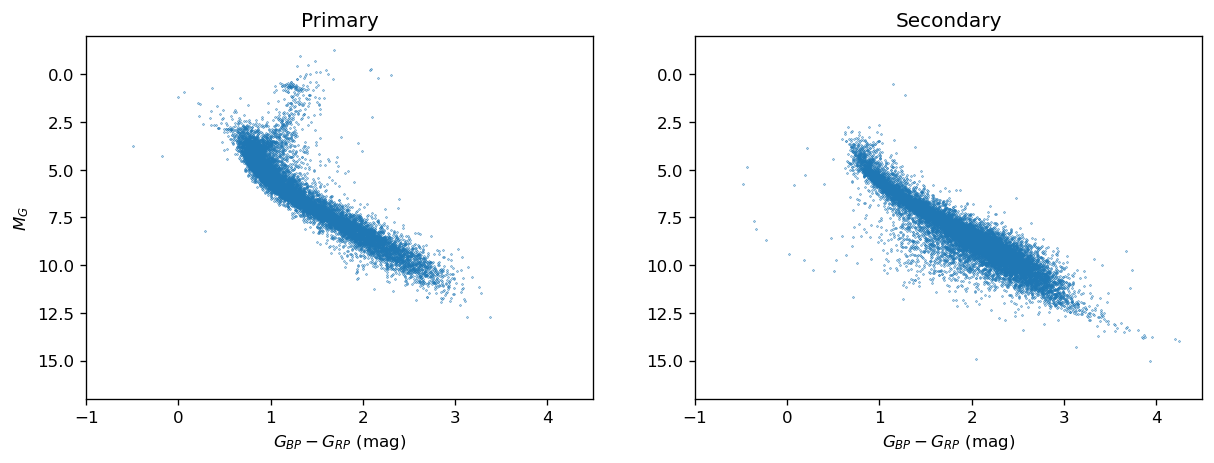

In [7]:
### CMDs for primary and secondary stars

fig = plt.figure(figsize=(12, 4), dpi= 120)
ax = fig.add_subplot(121)

ax.scatter(cdf_halo['color_p'], cdf_halo['mg_p'], s = 0.1)
ax.set_xlim([-1,4.5])
ax.set_ylim([-2,17])
ax.invert_yaxis()
ax.set_xlabel('$G_{BP} - G_{RP}$ (mag)')
ax.set_ylabel('$M_{G}$')
ax.set_title('Primary')

ax = fig.add_subplot(122)

ax.scatter(cdf_halo['color_s'], cdf_halo['mg_s'], s = 0.1)
ax.set_xlim([-1,4.5])
ax.set_ylim([-2,17])
ax.invert_yaxis()
ax.set_xlabel('$G_{BP} - G_{RP}$ (mag)')
ax.set_title('Secondary')

In [8]:
### Correct for extinction

### Load the bayestar map

from __future__ import print_function
import sys, os, time, fileinput

#UNCOMMENT TO INSTALL BAYESTAR MAP
#import dustmaps.bayestar
#dustmaps.bayestar.fetch()

from astropy.coordinates import SkyCoord
from dustmaps.bayestar import BayestarQuery

bs = BayestarQuery()

Configuration file not found:

    /home/edr/.dustmapsrc

To create a new configuration file in the default location, run the following python code:

    from dustmaps.config import config
    config.reset()

Note that this will delete your configuration! For example, if you have specified a data directory, then dustmaps will forget about its location.
Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 20.809 s
  pix_info:   0.401 s
   samples:  13.745 s
      best:   2.850 s
       nan:   0.019 s
      sort:   3.704 s
       idx:   0.090 s


In [9]:
## Generate reddening from Bayestar dustmap for each star
import astropy.units as units
coords_pri = SkyCoord(ra = cdf_halo['ra_p']*units.deg, dec = cdf_halo['dec_p']*units.deg, 
                      distance = cdf_halo['d_p']*units.pc, frame='icrs') # coordinates of primaries
cdf_halo['ebv_p'] = bs(coords_pri, mode = 'median') # reddening of primaries

coords_sec = SkyCoord(ra = cdf_halo['ra_s']*units.deg, dec = cdf_halo['dec_s']*units.deg, 
                      distance = cdf_halo['d_s']*units.pc, frame='icrs') # coordinates of secondaries
cdf_halo['ebv_s'] = bs(coords_sec, mode = 'median') # reddenings of secondaries

/tmp/ipykernel_132/1873483902.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf_halo['ebv_p'] = bs(coords_pri, mode = 'median') # reddening of primaries
/tmp/ipykernel_132/1873483902.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf_halo['ebv_s'] = bs(coords_sec, mode = 'median') # reddenings of secondaries


In [10]:
## Calculate extinction coefficients for every primary

from pyia.extinction import get_ext

A_list_p = get_ext(cdf_halo['g_p'],
                     cdf_halo['bp_p'],
                     cdf_halo['rp_p'],
                     cdf_halo['ebv_p'],maxnit=8 ) # extinction coefficients

cdf_halo['A_g_p'] = A_list_p[0] # G-band extinction coefficient
cdf_halo['A_bp_p'] = A_list_p[1] # G_BP-band extinction coefficient
cdf_halo['A_rp_p'] = A_list_p[2] # G_RP-band extinction coefficient

cdf_halo['g_int_p'] =  cdf_halo['g_p'] - cdf_halo['A_g_p'] # intrinsic G-mag
cdf_halo['bp_int_p'] = cdf_halo['bp_p'] - cdf_halo['A_bp_p'] # intrinsic bp-mag
cdf_halo['rp_int_p'] = cdf_halo['rp_p'] - cdf_halo['A_rp_p'] # intrinsic rp-mag
cdf_halo['color_int_p'] = cdf_halo['bp_int_p'] - cdf_halo['rp_int_p'] # intrinsic color index

cdf_halo['mg_int_p'] = cdf_halo['g_int_p'] - 5 * np.log10(cdf_halo['d_p']) + 5 # intrinsic absolute G-mag

## Calculate extinction coefficients for every secondary
A_list_s = get_ext(cdf_halo['g_s'],
                     cdf_halo['bp_s'],
                     cdf_halo['rp_s'],
                     cdf_halo['ebv_s'],maxnit=8 )

cdf_halo['A_g_s'] = A_list_s[0]
cdf_halo['A_bp_s'] = A_list_s[1]
cdf_halo['A_rp_s'] = A_list_s[2]

cdf_halo['g_int_s'] =  cdf_halo['g_s'] - cdf_halo['A_g_s']
cdf_halo['bp_int_s'] = cdf_halo['bp_s'] - cdf_halo['A_bp_s']
cdf_halo['rp_int_s'] = cdf_halo['rp_s'] - cdf_halo['A_rp_s']
cdf_halo['color_int_s'] = cdf_halo['bp_int_s'] - cdf_halo['rp_int_s'] 

cdf_halo['mg_int_s'] = cdf_halo['g_int_s'] - 5 * np.log10(cdf_halo['d_s']) + 5

/home/edr/anaconda3/lib/python3.9/site-packages/numpy/lib/polynomial.py:771: RuntimeWarning: overflow encountered in multiply
  y = y * x + p[i]
/tmp/ipykernel_132/2968336600.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf_halo['A_g_p'] = A_list_p[0] # G-band extinction coefficient
/tmp/ipykernel_132/2968336600.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf_halo['A_bp_p'] = A_list_p[1] # G_BP-band extinction coefficient
/tmp/ipykernel_132/2968336600.py:12: SettingWithCopyWarning: 
A value

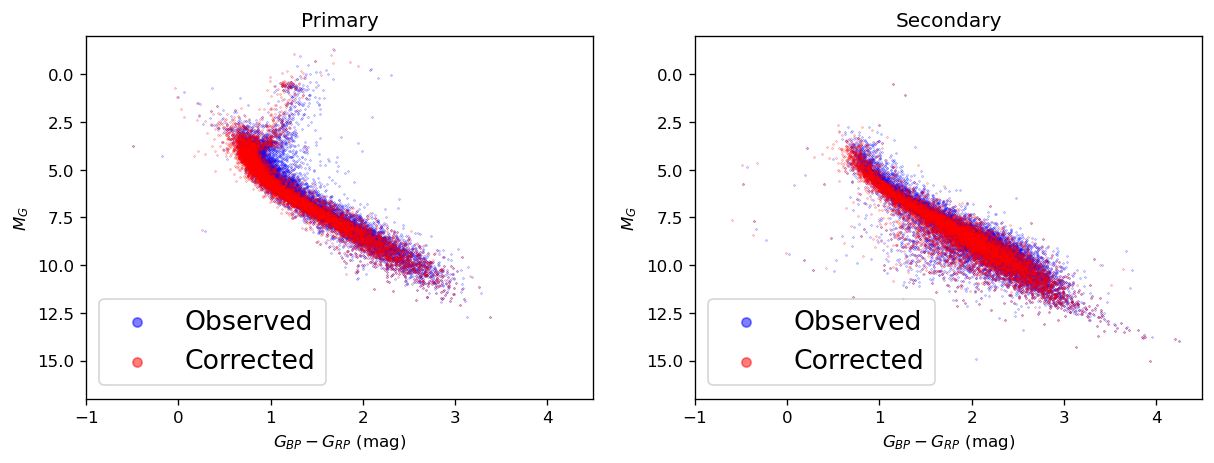

In [11]:
### Generate observed and extinction-corrected CMDs

fig = plt.figure(figsize=(12, 4), dpi= 120)
ax = fig.add_subplot(121)

ax.scatter(cdf_halo['color_p'], cdf_halo['mg_p'], s = 0.1, c = 'b', alpha = 0.5, label = 'Observed')
ax.scatter(cdf_halo['color_int_p'], cdf_halo['mg_int_p'], s = 0.1, c = 'r', alpha = 0.5, label = 'Corrected')
ax.set_xlim([-1,4.5])
ax.set_ylim([-2,17])
ax.invert_yaxis()
ax.set_xlabel('$G_{BP} - G_{RP}$ (mag)')
ax.set_ylabel('$M_{G}$')
ax.set_title('Primary')
ax.legend(loc = 'lower left')
lgnd = ax.legend(loc='lower left', ncol=1, fontsize=16)
for n in range(2):
    lgnd.legendHandles[n]._sizes = [30]

ax = fig.add_subplot(122)
ax.scatter(cdf_halo['color_s'], cdf_halo['mg_s'], s = 0.1, c = 'b', alpha = 0.5, label = 'Observed')
ax.scatter(cdf_halo['color_int_s'], cdf_halo['mg_int_s'], s = 0.1, c = 'r', alpha = 0.5, label = 'Corrected')
ax.set_xlim([-1,4.5])
ax.set_ylim([-2,17])
ax.invert_yaxis()
ax.set_xlabel('$G_{BP} - G_{RP}$ (mag)')
ax.set_ylabel('$M_{G}$')
ax.set_title('Secondary')
lgnd = ax.legend(loc='lower left', ncol=1, fontsize=16)
for n in range(2):
    lgnd.legendHandles[n]._sizes = [30]

Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


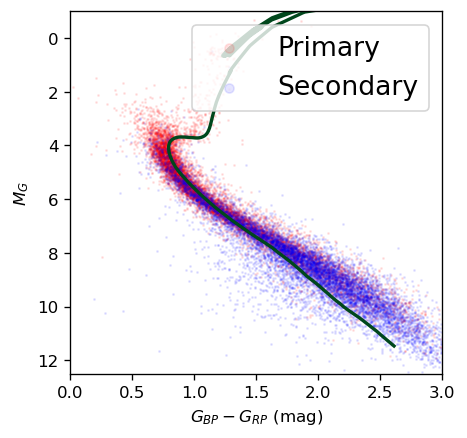

In [12]:
### Import MIST isochrones and plot some isochrones versus the extinction-corrected color-magnitude data
## Produce isochrones for stars of fixed age and varying metallicities

from isochrones.mist import MIST_Isochrone
mist = MIST_Isochrone()

Age = 10
log_Age = np.log10(Age * 10**9) # log_10 (Age/yr)
MH_list = [0] # [M/H] in units of dex
N_MH = len(MH_list)
    
fig = plt.figure(figsize=(4, 4), dpi= 120)
ax = fig.add_subplot(111)

## CMD of primaries and secondaries
ax.scatter(cdf_halo['color_int_p'], cdf_halo['mg_int_p'], s = 0.5, c = 'r', alpha = 0.1, label = 'Primary')
ax.scatter(cdf_halo['color_int_s'], cdf_halo['mg_int_s'], s = 0.5, c = 'b', alpha = 0.1, label = 'Secondary')

## Isochrone plots
# Set color gradient of isochrone plots
cmap = plt.get_cmap('Greens')
color_code = 0.99
color = cmap(color_code)

for MH in MH_list:
    str_MH = str(MH)
    midf = mist.isochrone(log_Age,MH) # dataframe for isochrone with given age and metallicity
    midf['color'] = midf['BP_mag'] - midf['RP_mag']
    midf['mg'] = midf['G_mag']
    ax.plot(midf['color'], midf['mg'], lw = 2, color = color, markersize = 1, alpha = 1)
    color_code -= 1/N_MH
    color = cmap(color_code)

ax.set_xlim([0,3])
ax.set_ylim([-1,12.5])
ax.invert_yaxis()
ax.set_xlabel('$G_{BP} - G_{RP}$ (mag)')
ax.set_ylabel('$M_{G}$')
lgnd = ax.legend(ncol=1, fontsize=16)
for n in range(N_MH+1):
    lgnd.legendHandles[n]._sizes = [30]
# ax.set_title(str(Age) + ' Gyr Isochrones')

In [13]:
### Estimate masses of each star by interpolating over isochrones

## Produce a list of isochrones used for interpolation
Age = 10 # Gyr
log_Age = np.log10(Age * 10**9) # log_10 (Age/yr)
MH_list = np.arange(-2.1,0.4+0.01,0.01)
N_MH = len(MH_list)

mist = MIST_Isochrone()

iso_mags = []
iso_mass = []
for MH in MH_list:
    midf = mist.isochrone(log_Age,MH)
    midf['color'] = midf['BP_mag'] - midf['RP_mag']
    midf['mg'] = midf['G_mag']
    iso = midf[['color','mg','mass','feh']].to_numpy(dtype = np.float32)
    iso_mags.append(iso[:,:-2])
    iso_mass.append(iso[:,2])

In [14]:
### "interpolator" function producing a mass for a given color-magnitude coordinate

def mass_generator(color,mg,tol_dist):
    ''' 
    This mass_generator estimates the masses of stars by finding the isochrone closest to the star's color-magnitude position. 
    The stellar coordinates and a maximum tolerated distance are provided as arguments. Points that are too far from the isochrones
    are not assigned a mass.
    
    Our notion of "distance" here was defined according to the qualitative slope of the isochrones. Converting this distance to 
    the standard Euclidean distance does not affect our results significantly. Our results also look good if the tolerated 
    distance is large.
    
    The isochrones are provides in the list given by the previous cell. 
    '''
    
    # check if star cannot be corrected for extinction via the bayestar map
    if np.isnan(mg) == True: 
        return np.nan
    
    # Find the isochrone color-magnitude nearest to color-magnitude coordinate of the star by
    # finding the minima among the points of each isochrone separately
    
    min_dists = [] ## list of minimum distances computed for each isochrone
    index_list = [] ## indices labelling the mass point corresponding to minimum distances for each isochrone
    N_MH = len(MH_list)
    
    for n_MH in range(N_MH):
        ## distance between points in color-magnitude space for an isochrone of fixed metallicity
        dists_MH = np.sqrt( (color - iso_mags[n_MH][:,0])**2. + 3.75**2.*(mg - iso_mags[n_MH][:,1])**2. )
        
        ## minimum distance between datapoint and isochrone points
        min_dist_MH = np.min(dists_MH)
        n_min_MH = np.where(dists_MH <= min_dist_MH + 0.01)[0][-1]
        
        min_dists.append(min_dist_MH)
        index_list.append(n_min_MH)
        
    min_dist = np.min(min_dists)
    
    if min_dist >= tol_dist: ## tolerated dist
        return np.nan
    n_min = np.where(min_dists <= min_dist + 0.01)[0][-1] ## find the index of the isochrone that is closest to the datapoint
    
    return iso_mass[n_min][index_list[n_min]] ## return the mass corresponding to the datapoint

In [15]:
### Produce masses for each primary and secondary in the catalog
### NOTE: We do not impose a strict tolerated distance here

## primary mass column
cdf_halo['mass_p'] = [
    
    mass_generator(
        cdf_halo['color_int_p'][n],
        cdf_halo['mg_int_p'][n],
        10)
    
    for n in range(N) ]

## secondary mass column
cdf_halo['mass_s'] = [
    
    mass_generator(
        cdf_halo['color_int_s'][n],
        cdf_halo['mg_int_s'][n],
        10)
    
    for n in range(N) ]

/tmp/ipykernel_132/799731211.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf_halo['mass_p'] = [
/tmp/ipykernel_132/799731211.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf_halo['mass_s'] = [


In [16]:
# Generate columns of true (nonphotometric) primary and secondary masses 

cdf_halo['mass_primary_true'] = np.maximum(cdf_halo['mass_p'], cdf_halo['mass_s'])
cdf_halo['mass_secondary_true'] = np.minimum(cdf_halo['mass_p'], cdf_halo['mass_s'])

/tmp/ipykernel_132/2757275256.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf_halo['mass_primary_true'] = np.maximum(cdf_halo['mass_p'], cdf_halo['mass_s'])
/tmp/ipykernel_132/2757275256.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf_halo['mass_secondary_true'] = np.minimum(cdf_halo['mass_p'], cdf_halo['mass_s'])


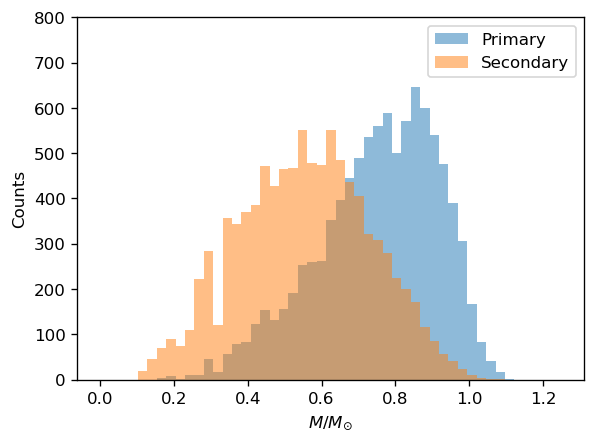

In [17]:
### Generate a histogram of the masses

fig = plt.figure(figsize=(12, 4), dpi= 120)

ax = fig.add_subplot(121)
counts, bins, _ = ax.hist(cdf_halo['mass_primary_true'], bins = np.linspace(0,1.25,50), alpha = 0.5)
counts, bins, _ = ax.hist(cdf_halo['mass_secondary_true'], bins = np.linspace(0,1.25,50), alpha = 0.5)
ax.set_xlabel('$M/M_{\odot}$')
ax.set_ylabel('Counts')
ax.set_ylim([0,800])
ax.legend(['Primary','Secondary'])

/tmp/ipykernel_132/3506116607.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  hb = ax.hexbin(cdf_halo['mass_primary_true'], cdf_halo['mass_secondary_true'], xscale = 'linear', yscale = 'linear', cmap = 'CMRmap',


Text(0.5, 1.0, 'Counts')

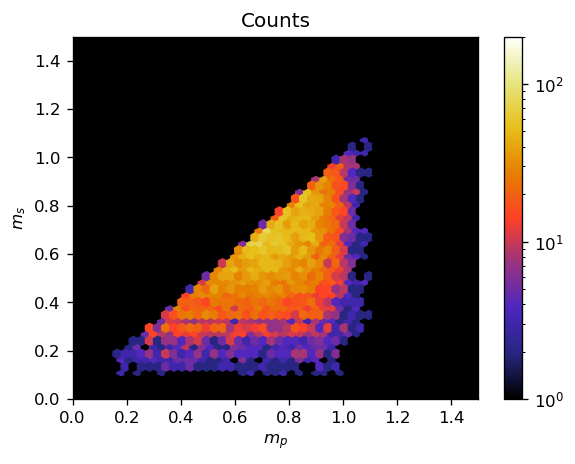

In [18]:
fig = plt.figure(figsize=(12, 4), dpi= 120)
ax = fig.add_subplot(121)

## Isochrone plots
# Set color gradient of isochrone plots

hb = ax.hexbin(cdf_halo['mass_primary_true'], cdf_halo['mass_secondary_true'], xscale = 'linear', yscale = 'linear', cmap = 'CMRmap', 
         gridsize = 50, bins = 'log', extent = (0,1.5,0,1.5), vmin = 1, vmax = 200)

cb = fig.colorbar(hb, ax = ax)
ax.set_xlim([0,1.5])
ax.set_ylim([0,1.5])
ax.set_xlabel('$m_{p}$')
ax.set_ylabel('$m_{s}$')
ax.set_title('Counts')

/tmp/ipykernel_132/1331162321.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf_halo['M'] = cdf_halo['mass_secondary_true'] + cdf_halo['mass_primary_true']


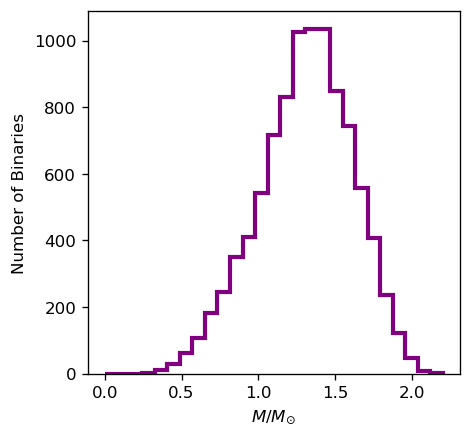

In [19]:
### Generate a histogram of the total masses

fig = plt.figure(figsize=(4, 4), dpi= 120)

cdf_halo['M'] = cdf_halo['mass_secondary_true'] + cdf_halo['mass_primary_true']
ax = fig.add_subplot(111)
counts, bins, _ = ax.hist((cdf_halo['M']) , bins = np.linspace(0,2.2,28), color = 'purple', alpha = 1, histtype = 'step', lw = 2.5, density = False)
ax.set_xlabel('$M/M_{\odot}$')
ax.set_ylabel('Number of Binaries')
# ax.set_ylim([0,3])

np.save('M_data'+ '_' + str_R_chance_align + '_' + str(scut), cdf_halo['M'])

In [21]:
# save halo catalog dataframe (without completeness cut) to include masses
cdf_halo.to_pickle('halo_catalog_dataframe' + '_' + str_R_chance_align + '_' + str_scut + '.pkl')

---
---
---

In [27]:
# Basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [28]:
# selection function cut
from scipy.interpolate import interp1d

## Preload selection function matrix
def selection_fct_edr3(theta,theta0):
    beta = 5.    #eDR3 10 -> 5   
    f_val = 1/(1 + (theta/theta0)**(-beta))
    return f_val
selection_fct_vec_edr3 = np.vectorize(selection_fct_edr3)

# Theta_0 values obtained via interpolation of fits of theta_0 on delta_G bins performed by El-Badry
## El-Badry repeated the analysis from Appendix A in arXiv:1807.06011v2 to perform the interpolation
## See theta0_edr3.pdf and fraction_of_pairs_detected_edr3.pdf in directory for results

delta_G_mid = [0.5,1.5,2.5,3.5,5,7,9.5]
theta_0_values = [0.77, 0.82, 0.99, 1.16, 1.57, 2.40, 3.01]
theta_0 = interp1d(delta_G_mid, theta_0_values, kind = 'linear', fill_value = 'extrapolate', assume_sorted = True)

Text(0, 0.5, '$\\theta_{0}$ (as)')

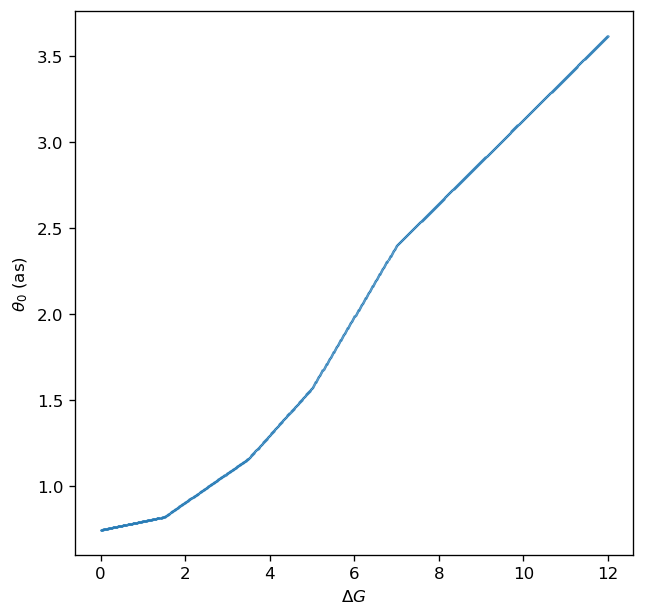

In [29]:
fig = plt.figure(figsize=(6,6), dpi= 120)
ax = fig.add_subplot(111)

delta_G_list = np.linspace(0,12,1000)
ax.scatter(delta_G_list, theta_0(delta_G_list), s = 0.1)
ax.set_xlabel('$\\Delta G$')
ax.set_ylabel('$\\theta_{0}$ (as)')

In [30]:
thetalist = np.linspace(0,20,10000)

theta_cut_vals = []
for n in range(len(delta_G_mid)):
    theta0 = theta_0_values[n]
    selection_fct_vals = selection_fct_edr3(thetalist,theta0)
    theta_0 = interp1d(selection_fct_vals, thetalist, kind = 'linear', fill_value = 'extrapolate', assume_sorted = True)
    theta_cut_vals.append(theta_0(0.999))

/tmp/ipykernel_179/244085798.py:7: RuntimeWarning: divide by zero encountered in power
  f_val = 1/(1 + (theta/theta0)**(-beta))


Text(0, 0.5, '$\\theta_{\\Delta G}$ (as)')

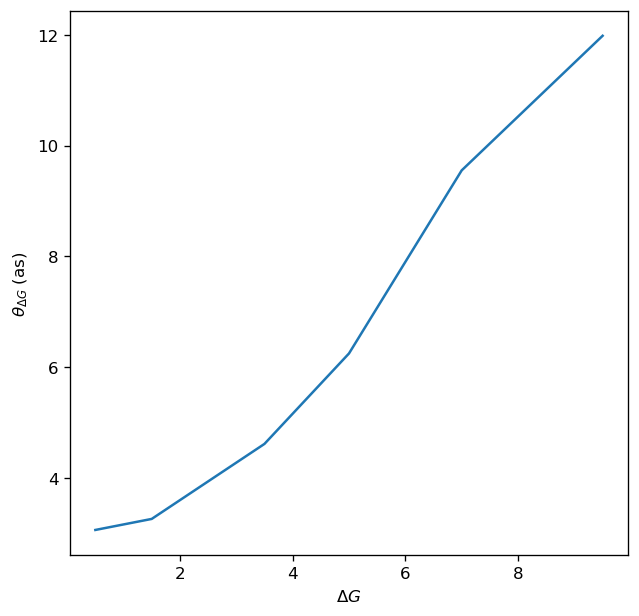

In [31]:
fig = plt.figure(figsize=(6,6), dpi= 120)
ax = fig.add_subplot(111)

delta_G_list = np.linspace(0,12,1000)
ax.plot(delta_G_mid, theta_cut_vals)
ax.set_xlabel('$\\Delta G$')
ax.set_ylabel('$\\theta_{\Delta G}$ (as)')

In [32]:
R_chance_align = 1.0
str_R_chance_align = str(R_chance_align)

scut = 1
str_scut = str(float(scut))

## Load catalog (updated for loading eDR3 halo subsample)
catalog_name = 'halo_catalog_dataframe' + '_' + str_R_chance_align + '_' + str_scut + '.pkl'
cdf_halo = pd.read_pickle(catalog_name)

In [33]:
cdf_halo['distance1'] = 1000 * (1/cdf_halo['parallax1'])    # pc
cdf_halo['delta_G'] = np.abs(cdf_halo['phot_g_mean_mag1'] - cdf_halo['phot_g_mean_mag2'])  # mag

delta_G_mid = [0.5,1.5,2.5,3.5,5,7,9.5]

theta_cut_vals = [3.06481262,  3.26382633,  3.94047254,  4.61711977,  6.24903233,  9.55266057, 11.98062847]
theta_cut_ = interp1d(delta_G_mid, theta_cut_vals, kind = 'linear', fill_value = 'extrapolate', assume_sorted = True)

cdf_halo['delta_G'] = np.abs( cdf_halo['phot_g_mean_mag1'] - cdf_halo['phot_g_mean_mag2'] )
cdf_halo['theta_cut'] = theta_cut_(cdf_halo['delta_G'])
cdf_theta_cut = cdf_halo[ cdf_halo['pairdistance_arcsec'] > cdf_halo['theta_cut'] ]
cdf_theta_cut.reset_index(drop=True, inplace=True)

cdf_theta_cut.sort_values(by=['sep_pc'], inplace=True)
cdf_theta_cut.reset_index(drop=True, inplace=True)
catalog_data_halo = cdf_theta_cut[['sep_pc', 'distance1', 'delta_G', 'R_chance_align']].to_numpy()
catalog_sep_vec = [catalog_data_halo[n][0] for n in range(len(cdf_theta_cut))]  #pc
catalog_dist_vec = [catalog_data_halo[n][1] for n in range(len(cdf_theta_cut))]   #pc
catalog_delta_G_vec = [catalog_data_halo[n][2] for n in range(len(cdf_theta_cut))]    #au
catalog_R_chance_align_vec = [catalog_data_halo[n][3] for n in range(len(cdf_theta_cut))]   

/home/edr/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [34]:
# organize data in a way that can be loaded in the statistics code to set limits
catalog_data = [catalog_sep_vec, catalog_dist_vec, catalog_delta_G_vec, catalog_R_chance_align_vec]

catalog_name = 'catalog_data' + '_' + '1.0' + '_' + '1.0' + '_cut_err'
np.save(catalog_name, catalog_data)

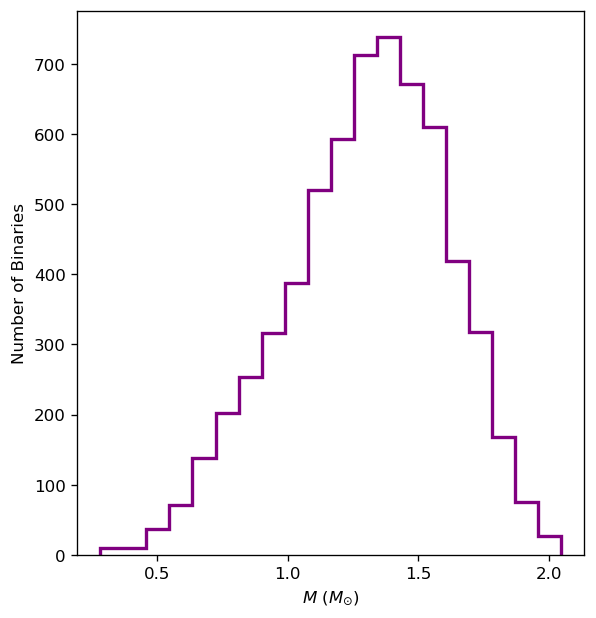

In [35]:
fig_mass = plt.figure(figsize=(12, 6), dpi= 120)

ax = fig_mass.add_subplot(122)

# histogram of masses
counts, bins, _ = ax.hist((cdf_theta_cut['M']) , bins = np.linspace(np.min(cdf_theta_cut['M']),np.max(cdf_theta_cut['M']),21), 
                          color = 'purple', alpha = 1, histtype = 'step', lw = 2, density = False)
ax.set_xlabel('$M \ (M_{\odot})$')
ax.set_ylabel('Number of Binaries')
ax.set_xticks(np.arange(0.5, 2+0.5, 0.5))
ax.tick_params(axis='both', which='major')

In [36]:
# save M_data numpy array used for evolution code
M_data = cdf_theta_cut['M'].to_numpy()
np.save('M_data_cut'+ '_' + str_R_chance_align + '_' + str(scut), M_data)